# Locally Linear Embedding

- Non-linear
- Preserve the neighbourhood relations in the data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets
mpl.rcParams['figure.figsize'] = 3, 2
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 8

iris = datasets.load_iris()

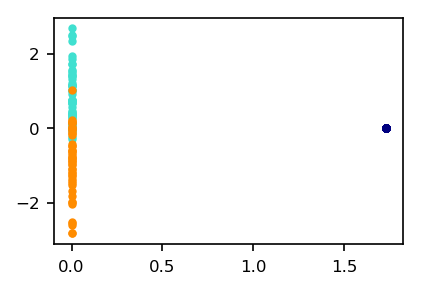

In [11]:
import pylab as pl
import numpy as np

def lle(data,nRedDim=2,K=20):

	ndata = np.shape(data)[0]
	ndim = np.shape(data)[1]
	d = np.zeros((ndata,ndata),dtype=float)
	
	# Inefficient -- not matrices
	for i in range(ndata):
		for j in range(i+1,ndata):
			for k in range(ndim):
				d[i,j] += (data[i,k] - data[j,k])**2
			d[i,j] = np.sqrt(d[i,j])
			d[j,i] = d[i,j]

	indices = d.argsort(axis=1)
	neighbours = indices[:,1:K+1]

	W = np.zeros((K,ndata),dtype=float)

	for i in range(ndata):
		Z  = data[neighbours[i,:],:] - np.kron(np.ones((K,1)),data[i,:])
		C = np.dot(Z,np.transpose(Z))
		C = C+np.identity(K)*1e-3*np.trace(C)
		W[:,i] = np.transpose(np.linalg.solve(C,np.ones((K,1))))
		W[:,i] = W[:,i]/np.sum(W[:,i])

	M = np.eye(ndata,dtype=float)
	for i in range(ndata):
		w = np.transpose(np.ones((1,np.shape(W)[0]))*np.transpose(W[:,i]))
		j = neighbours[i,:]
		#print shape(w), np.shape(np.dot(w,np.transpose(w))), np.shape(M[i,j])
		ww = np.dot(w,np.transpose(w))
		for k in range(K):
			M[i,j[k]] -= w[k]
			M[j[k],i] -= w[k]
			for l in range(K):
			     M[j[k],j[l]] += ww[k,l]
	
	evals,evecs = np.linalg.eig(M)
	ind = np.argsort(evals)
	y = evecs[:,ind[1:nRedDim+1]]*np.sqrt(ndata)
	return evals,evecs,y


evals,evecs,y = lle(iris.data)


t = iris.target
for i, c in zip(target_ids, colors):
    plt.scatter(y[ i == t,0], y[i == t,1], c = c, marker='.')
plt.show()

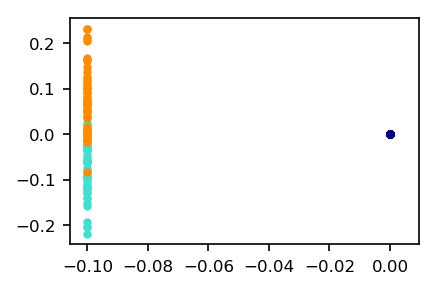

In [10]:
from sklearn.manifold import LocallyLinearEmbedding
labels = iris.target
embedding = LocallyLinearEmbedding(20, n_components=2)
X_lle = embedding.fit_transform(iris.data)
target_ids = np.unique(labels)
y = iris.target
X_lle.shape
(100, 2)

colors = ['navy', 'turquoise', 'darkorange']
for i, c in zip(target_ids, colors):
    plt.scatter(X_lle[ i == y,0], X_lle[i == y,1], c = c, marker='.')
plt.show()

## References
[
Machine Learning: An Algorithmic Perspective: Stephen Marsland ](http://dai.fmph.uniba.sk/courses/ICI/References/marsland.machine-learning.2ed.2015.pdf)